### IMPORTS

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### LOAD DATAFRAME

In [175]:
pd.options.display.max_columns
df = pd.read_csv('df_complete.csv')
df = df.drop('Unnamed: 0', axis=1)
df

,GAME_ID,HOME_TEAM_ID,VISITOR_TEAM_ID,HOME_TEAM_ABBREVIATION,HOME_TEAM_NICKNAME,VISITOR_TEAM_ABBREVIATION,VISITOR_TEAM_NICKNAME,SEASON,GAME_DATE,FG_PCT_home,...,AVG_FGPERCENT_LAST10_VISITOR_TEAM.1,AVG_FG3PCT_UNTIL_THIS_GAME_VISITOR_TEAM,AVG_FG3PCT_LAST5_VISITOR_TEAM,AVG_FG3PCT_LAST10_VISITOR_TEAM,AST_home.1,REB_home.1,HOME_TEAM_WINS,VISITOR_TEAM_WINS,PTS_home,PTS_away
0,20300001,1610612755,1610612748,PHI,76ers,MIA,Heat,2003,2003-10-28,0.440,...,0.4185,0.358317,0.3632,0.3776,25.0,39.0,1,0,89.0,74.0
1,20300002,1610612759,1610612756,SAS,Spurs,PHX,Suns,2003,2003-10-28,0.425,...,0.4537,0.340049,0.4792,0.3745,20.0,38.0,1,0,83.0,82.0
2,20300003,1610612747,1610612742,LAL,Lakers,DAL,Mavericks,2003,2003-10-28,0.506,...,0.5147,0.347183,0.3966,0.4257,32.0,46.0,1,0,109.0,93.0
3,20300004,1610612738,1610612748,BOS,Celtics,MIA,Heat,2003,2003-10-29,0.507,...,0.4185,0.358317,0.3632,0.3776,28.0,40.0,1,0,98.0,75.0
4,20300005,1610612752,1610612753,NYK,Knicks,ORL,Magic,2003,2003-10-29,0.400,...,0.4200,0.341780,0.2478,0.3035,20.0,48.0,0,1,83.0,85.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19393,21801226,1610612749,1610612760,MIL,Bucks,OKC,Thunder,2018,2019-04-10,0.430,...,0.4530,0.351329,0.3874,0.3648,27.0,53.0,0,1,116.0,127.0
19394,21801227,1610612759,1610612742,SAS,Spurs,DAL,Mavericks,2018,2019-04-10,0.466,...,0.4527,0.341451,0.3062,0.3372,22.0,53.0,1,0,105.0,94.0
19395,21801228,1610612743,1610612750,DEN,Nuggets,MIN,Timberwolves,2018,2019-04-10,0.448,...,0.4674,0.355329,0.3708,0.3819,23.0,53.0,1,0,99.0,95.0
19396,21801229,1610612746,1610612762,LAC,Clippers,UTA,Jazz,2018,2019-04-10,0.509,...,0.5079,0.354500,0.4070,0.4035,34.0,52.0,1,0,143.0,137.0


In [99]:
df = df[['GAME_ID', 'HOME_TEAM_ID', 'VISITOR_TEAM_ID', 'HOME_TEAM_ABBREVIATION', 'HOME_TEAM_NICKNAME',\
         'VISITOR_TEAM_ABBREVIATION', 'VISITOR_TEAM_NICKNAME', 'SEASON','GAME_DATE', \
         'FG_PCT_home','FT_PCT_home', 'FG3_PCT_home', 'PERCENT_VIC_UNITL_THIS_GAME_HOME_TEAM', \
         'PERCENT_VIC_LAST5_GAMES_HOME_TEAM', 'PERCENT_VIC_LAST10_GAMES_HOME_TEAM', \
         'AVG_POINTS_UNTIL_THIS_GAME_HOME_TEAM', 'AVG_POINTS_LAST5_HOME_TEAM', 'AVG_POINTS_LAST10_HOME_TEAM', \
         'AVG_FGPERCENT_UNTIL_THIS_GAME_HOME_TEAM', 'AVG_FGPERCENT_LAST5_HOME_TEAM', \
         'AVG_FGPERCENT_LAST10_HOME_TEAM', 'AVG_FGPERCENT_LAST10_HOME_TEAM', 'AVG_FG3PCT_UNTIL_THIS_GAME_HOME_TEAM',\
         'AVG_FG3PCT_LAST5_HOME_TEAM', 'AVG_FG3PCT_LAST10_HOME_TEAM', 'AST_home', 'REB_home', \
         'FG_PCT_away','FT_PCT_away', 'FG3_PCT_away', 'PERCENT_VIC_UNITL_THIS_GAME_VISITOR_TEAM', \
         'PERCENT_VIC_LAST5_GAMES_VISITOR_TEAM', 'PERCENT_VIC_LAST10_GAMES_VISITOR_TEAM', \
         'AVG_POINTS_UNTIL_THIS_GAME_VISITOR_TEAM', 'AVG_POINTS_LAST5_VISITOR_TEAM','AVG_POINTS_LAST10_VISITOR_TEAM', \
         'AVG_FGPERCENT_UNTIL_THIS_GAME_VISITOR_TEAM', 'AVG_FGPERCENT_LAST5_VISITOR_TEAM', \
         'AVG_FGPERCENT_LAST10_VISITOR_TEAM', 'AVG_FGPERCENT_LAST10_VISITOR_TEAM', \
         'AVG_FG3PCT_UNTIL_THIS_GAME_VISITOR_TEAM', 'AVG_FG3PCT_LAST5_VISITOR_TEAM', 'AVG_FG3PCT_LAST10_VISITOR_TEAM',\
         'AST_home', 'REB_home', 'HOME_TEAM_WINS', 'VISITOR_TEAM_WINS', 'PTS_home', 'PTS_away']]
df

,GAME_ID,HOME_TEAM_ID,VISITOR_TEAM_ID,HOME_TEAM_ABBREVIATION,HOME_TEAM_NICKNAME,VISITOR_TEAM_ABBREVIATION,VISITOR_TEAM_NICKNAME,SEASON,GAME_DATE,FG_PCT_home,...,AVG_FGPERCENT_LAST10_VISITOR_TEAM,AVG_FG3PCT_UNTIL_THIS_GAME_VISITOR_TEAM,AVG_FG3PCT_LAST5_VISITOR_TEAM,AVG_FG3PCT_LAST10_VISITOR_TEAM,AST_home,REB_home,HOME_TEAM_WINS,VISITOR_TEAM_WINS,PTS_home,PTS_away
0,20300001,1610612755,1610612748,PHI,76ers,MIA,Heat,2003,2003-10-28,0.440,...,0.4185,0.358317,0.3632,0.3776,25.0,39.0,1,0,89.0,74.0
1,20300002,1610612759,1610612756,SAS,Spurs,PHX,Suns,2003,2003-10-28,0.425,...,0.4537,0.340049,0.4792,0.3745,20.0,38.0,1,0,83.0,82.0
2,20300003,1610612747,1610612742,LAL,Lakers,DAL,Mavericks,2003,2003-10-28,0.506,...,0.5147,0.347183,0.3966,0.4257,32.0,46.0,1,0,109.0,93.0
3,20300004,1610612738,1610612748,BOS,Celtics,MIA,Heat,2003,2003-10-29,0.507,...,0.4185,0.358317,0.3632,0.3776,28.0,40.0,1,0,98.0,75.0
4,20300005,1610612752,1610612753,NYK,Knicks,ORL,Magic,2003,2003-10-29,0.400,...,0.4200,0.341780,0.2478,0.3035,20.0,48.0,0,1,83.0,85.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19393,21801226,1610612749,1610612760,MIL,Bucks,OKC,Thunder,2018,2019-04-10,0.430,...,0.4530,0.351329,0.3874,0.3648,27.0,53.0,0,1,116.0,127.0
19394,21801227,1610612759,1610612742,SAS,Spurs,DAL,Mavericks,2018,2019-04-10,0.466,...,0.4527,0.341451,0.3062,0.3372,22.0,53.0,1,0,105.0,94.0
19395,21801228,1610612743,1610612750,DEN,Nuggets,MIN,Timberwolves,2018,2019-04-10,0.448,...,0.4674,0.355329,0.3708,0.3819,23.0,53.0,1,0,99.0,95.0
19396,21801229,1610612746,1610612762,LAC,Clippers,UTA,Jazz,2018,2019-04-10,0.509,...,0.5079,0.354500,0.4070,0.4035,34.0,52.0,1,0,143.0,137.0


In [123]:
X = df.iloc[:,9:44].values
y = df.iloc[:,45].values
y=y.astype('int')

#X_copy = X.copy()
#X_norm = (X_copy - X_copy.mean()) / X_copy.std()



In [162]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report, confusion_matrix

In [163]:
#Gaussian

In [171]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

gnb = GaussianNB()
gnb.fit(X_train, y_train)

y_pred = gnb.predict(X_test)

print("% de acierto: ")
print(np.mean(y_pred == y_test))
print("Matrix Confusion: ")
print(confusion_matrix(y_test,y_pred))
print("Clasification report: ")
print(classification_report(y_test,y_pred))

% de acierto: 
0.7818556701030928
Matrix Confusion: 
[[1501  458]
 [ 600 2291]]
Clasification report: 
              precision    recall  f1-score   support

           0       0.71      0.77      0.74      1959
           1       0.83      0.79      0.81      2891

    accuracy                           0.78      4850
   macro avg       0.77      0.78      0.78      4850
weighted avg       0.79      0.78      0.78      4850



In [ ]:
#Gaussian no standard

In [145]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

gnb = GaussianNB()
gnb.fit(X_train, y_train)

y_pred = gnb.predict(X_test)

np.mean(y_pred == y_test)

0.7818556701030928

In [ ]:
#Logistic regression

In [172]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

logr = LogisticRegression()
logr.fit(X_train, y_train)

y_pred = logr.predict(X_test)

np.mean(y_pred == y_test)

print("% de acierto: ")
print(np.mean(y_pred == y_test))
print("Matrix Confusion: ")
print(confusion_matrix(y_test,y_pred))
print("Clasification report: ")
print(classification_report(y_test,y_pred))

% de acierto: 
0.8575257731958763
Matrix Confusion: 
[[1595  364]
 [ 327 2564]]
Clasification report: 
              precision    recall  f1-score   support

           0       0.83      0.81      0.82      1959
           1       0.88      0.89      0.88      2891

    accuracy                           0.86      4850
   macro avg       0.85      0.85      0.85      4850
weighted avg       0.86      0.86      0.86      4850



In [ ]:
#Logistic regression no satandard

In [147]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

logr = LogisticRegression()
logr.fit(X_train, y_train)

y_pred = logr.predict(X_test)

np.mean(y_pred == y_test)

/home/dsc/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7868041237113402

In [ ]:
#SVC

In [173]:
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.25, 
    random_state=0,
    shuffle = True)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

svc = SVC()
svc.fit(X_train, y_train)

y_pred = svc.predict(X_test)

np.mean(y_pred == y_test)

print("% de acierto: ")
print(np.mean(y_pred == y_test))
print("Matrix Confusion: ")
print(confusion_matrix(y_test,y_pred))
print("Clasification report: ")
print(classification_report(y_test,y_pred))

% de acierto: 
0.8579381443298969
Matrix Confusion: 
[[1596  363]
 [ 326 2565]]
Clasification report: 
              precision    recall  f1-score   support

           0       0.83      0.81      0.82      1959
           1       0.88      0.89      0.88      2891

    accuracy                           0.86      4850
   macro avg       0.85      0.85      0.85      4850
weighted avg       0.86      0.86      0.86      4850



In [ ]:
#SVC no standard

In [151]:
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.25, 
    random_state=0)

svc = SVC()
svc.fit(X_train, y_train)

y_pred = svc.predict(X_test)

np.mean(y_pred == y_test)

0.7472164948453608

In [153]:
def evaluate_ROC(estimator, data, target):

    X_train, X_test, y_train, y_test = train_test_split(data,target, test_size=0.25)
    
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)

    estimator.fit(X_train, y_train)
    y_hat = estimator.predict(X_test)
    probs = estimator.predict_proba(X_test)[:,1]

    # plotear curva roc
    fpr, tpr, thresholds = roc_curve(y_test, probs)
    f, ax = plt.subplots(1,1)
    f.set_size_inches(8,7)
    ax.plot(fpr,tpr)
    ax.plot([0,1], [0,1], c='grey')

    print(f'acc: {accuracy_score(y_test, y_hat):.3} \
    recall: {recall_score(y_test, y_hat):.3} \
    precision:{precision_score(y_test, y_hat):.3} \
    f1:{f1_score(y_test, y_hat):.3} \
    auc:{roc_auc_score(y_test, probs):.3}')

acc: 0.777     recall: 0.792     precision:0.83     f1:0.811     auc:0.859


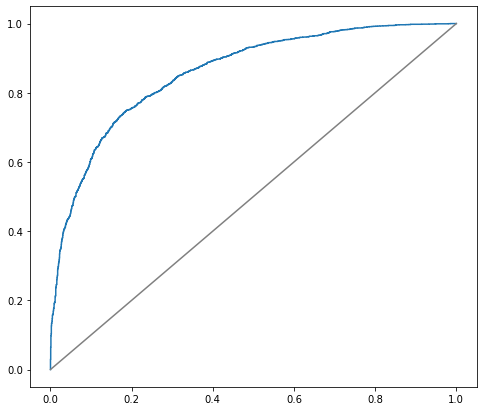

In [156]:
gnb = GaussianNB()
evaluate_ROC(gnb, X, y)

acc: 0.86     recall: 0.891     precision:0.874     f1:0.882     auc:0.933


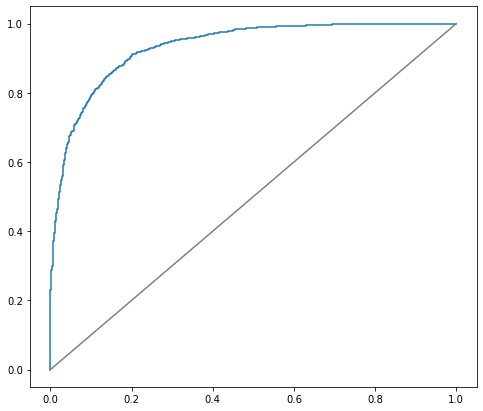

In [157]:
logR = LogisticRegression()
evaluate_ROC(logR, X, y)

In [160]:
# Grid de hiperparámetros
# ==============================================================================
param_grid = {'C': np.logspace(-5, 7, 20)}

# Búsqueda por validación cruzada
# ==============================================================================
grid = GridSearchCV(
        estimator  = SVC(kernel= "rbf", gamma='scale'),
        param_grid = param_grid,
        scoring    = 'accuracy',
        n_jobs     = -1,
        cv         = 3, 
        verbose    = 0,
        return_train_score = True
      )

# Se asigna el resultado a _ para que no se imprima por pantalla
_ = grid.fit(X = X_train, y = y_train)

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False) \
    .head(5)

,param_C,mean_test_score,std_test_score,mean_train_score,std_train_score
7,0.263665,0.857574,0.006104,0.875103,0.000385
8,1.128838,0.856475,0.005745,0.899093,0.000977
6,0.061585,0.849120,0.005982,0.855581,0.001274
9,4.83293,0.844445,0.006044,0.940026,0.001044
5,0.014384,0.821212,0.006630,0.824649,0.002948


### EVALUATION FUNCTION

In [3]:
def evaluar_metricas(estimator, data, target, name):
    
    X_train, X_test, y_train, y_test = train_test_split(data,target)

    estimator.fit(X_train, y_train)
    y_hat = estimator.predict(X_test)

    errors = y_test - y_hat
    mae = np.mean(np.abs(errors))
    mse = np.mean(errors ** 2)
    rmse = np.sqrt(mse)
    
    return [name, mse, rmse, mae]

### TARGET AND DATA SELECTION

#### 1) FG_PCT_home, FG_PCT_away, FG3_PCT_home, FG3_PCT_away

In [5]:
target_1 = df['HOME_TEAM_WINS']
data_1 = df[['FG_PCT_home', 'FG_PCT_away', 'FG3_PCT_home', 'FG3_PCT_away']]

data_copy_1 = data_1.copy()
normalized_data_1 = (data_copy_1 - data_copy_1.mean()) / data_copy_1.std()

#### 2) FG_PCT_home, FG_PCT_away, FG3_PCT_home, FG3_PCT_away, AST_home, REB_home, AST_away, REB_away

In [6]:
target_2 = df['HOME_TEAM_WINS']
data_2 = df[['FG_PCT_home','FG_PCT_away','FG3_PCT_home','FG3_PCT_away','AST_home','REB_home','AST_away','REB_away']]

data_copy_2 = data_2.copy()
normalized_data_2 = (data_copy_2 - data_copy_2.mean()) / data_copy_2.std()

#### ¿QUE OPCION ES MEJOR?, COMO DETERMINO SI DEBO COGER MAS O MENOS ESTADISTICAS PARA EL ALGORITMO

### ALGORITHMS:

### K Neighbors Regressor (KNR)

In [6]:
metrics_results_knr_1 = pd.DataFrame(columns=['NAME', 'MSE','RMSE', 'MAE'])

In [7]:
for n in range(1, 21):    
    for i in range(1, 501, 20):
        knr = KNeighborsRegressor(n_neighbors=i)
        metrics_results_knr_1.loc[len(metrics_results_knr_1)+1] = \
            evaluar_metricas(knr, 
                             normalized_data_1,
                             target_1, 
                             'knr_normalized_neighbors_'+str(i))

metrics_results_knr_1.to_csv('metrics_results_knr_1.csv')

In [8]:
metrics_results_knr_2 = pd.DataFrame(columns=['NAME', 'MSE','RMSE', 'MAE'])

In [9]:
for n in range(1, 21):    
    for i in range(1, 501, 20):
        knr = KNeighborsRegressor(n_neighbors=i)
        metrics_results_knr_2.loc[len(metrics_results_knr_2)+1] = \
            evaluar_metricas(knr, 
                             normalized_data_2,
                             target_2, 
                             'knr_normalized_neighbors_'+str(i))

metrics_results_knr_2.to_csv('metrics_results_knr_2.csv')

### Decision Tree Regressor (DTR)

In [11]:
metrics_results_dtr_1 = pd.DataFrame(columns=['NAME', 'MSE','RMSE', 'MAE'])

In [12]:
for n in range(1, 21):  
    for i in range(1, 301, 30):
        for j in range(1, 301, 30):
            dtr = DecisionTreeRegressor(max_depth=i, min_samples_leaf=j)
            metrics_results_dtr_1.loc[len(metrics_results_dtr_1)+1] = \
                evaluar_metricas(dtr, 
                                 normalized_data_1, 
                                 target_1, 
                                 'dtr_normalized__maxdepth_'+str(i)+'__minsamplesleaf_'+str(j))
            
metrics_results_dtr_1.to_csv('metrics_results_dtr_1.csv')

In [13]:
metrics_results_dtr_2 = pd.DataFrame(columns=['NAME', 'MSE','RMSE', 'MAE'])

In [14]:
for n in range(1, 21):  
    for i in range(1, 301, 30):
        for j in range(1, 301, 30):
            dtr = DecisionTreeRegressor(max_depth=i, min_samples_leaf=j)
            metrics_results_dtr_2.loc[len(metrics_results_dtr_2)+1] = \
                evaluar_metricas(dtr, 
                                 normalized_data_2, 
                                 target_2, 
                                 'dtr_normalized__maxdepth_'+str(i)+'__minsamplesleaf_'+str(j))
            
metrics_results_dtr_2.to_csv('metrics_results_dtr_2.csv')

### Random Forest Regressor (RFR)

In [15]:
metrics_results_rfr_1 = pd.DataFrame(columns=['NAME', 'MSE','RMSE', 'MAE'])

In [16]:
for n in range(1, 21): 
    for k in range(1, 101, 10):
        for i in range(1, 101, 10):
            for j in range(1, 101, 10):
                rfr = RandomForestRegressor(n_estimators=k, max_depth=i, min_samples_leaf=j)
                metrics_results_rfr_1.loc[len(metrics_results_rfr_1)+1] = \
                    evaluar_metricas(rfr, 
                                     normalized_data_1,
                                     target_1,
                                     'rfr_normalized__estimators_'+str(k)+
                                     '__maxdepth_'+str(i)+
                                     '__minsamplesleaf_'+str(j))
    
metrics_results_rfr_1.to_csv('metrics_results_rfr_1.csv')

In [11]:
metrics_results_rfr_2 = pd.DataFrame(columns=['NAME', 'MSE','RMSE', 'MAE'])

In [12]:
for n in range(1, 21): 
    for k in range(1, 101, 10):
        for i in range(1, 101, 10):
            for j in range(1, 101, 10):
                rfr = RandomForestRegressor(n_estimators=k, max_depth=i, min_samples_leaf=j)
                metrics_results_rfr_2.loc[len(metrics_results_rfr_2)+1] = \
                    evaluar_metricas(rfr, 
                                     normalized_data_2,
                                     target_2,
                                     'rfr_normalized__estimators_'+str(k)+
                                     '__maxdepth_'+str(i)+
                                     '__minsamplesleaf_'+str(j))
    
metrics_results_rfr_2.to_csv('metrics_results_rfr_2.csv')

### Multi-layer Perceptron Regressor (MLPR)

In [ ]:
metrics_results_mlpr_1 = pd.DataFrame(columns=['NAME', 'MSE','RMSE', 'MAE'])

In [ ]:
activations = ['relu', 'logistic', 'tanh']
solvers = ['adam', 'sgd']
learning_rates = ['constant', 'invscaling', 'adaptive']
batch_sizes = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]

for n in range(1, 21): 
    for act in activations:
        for sol in solvers:
            for rate in learning_rates:
                for size in batch_sizes:
                    mlpr = MLPRegressor(activation=act, solver=sol, batch_size=size, learning_rate=rate)
                    metrics_results_mlpr_1.loc[len(metrics_results_mlpr_1)+1] = \
                        evaluar_metricas(mlpr, 
                                         normalized_data_1,
                                         target_1, 
                                         'mlpr_normalized__activation_'+act+
                                         '__solver_'+sol+
                                         '__batchsize_'+str(size)+
                                         '__learningrate_'+rate)
                
metrics_results_mlpr_1.to_csv('metrics_results_mlpr_1.csv')

In [ ]:
metrics_results_mlpr_2 = pd.DataFrame(columns=['NAME', 'MSE','RMSE', 'MAE'])

In [ ]:
activations = ['relu', 'logistic', 'tanh']
solvers = ['adam', 'sgd']
learning_rates = ['constant', 'invscaling', 'adaptive']
batch_sizes = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]

for n in range(1, 21): 
    for act in activations:
        for sol in solvers:
            for rate in learning_rates:
                for size in batch_sizes:
                    mlpr = MLPRegressor(activation=act, solver=sol, batch_size=size, learning_rate=rate)
                    metrics_results_mlpr_2.loc[len(metrics_results_mlpr_2)+1] = \
                        evaluar_metricas(mlpr, 
                                         normalized_data_2,
                                         target_2, 
                                         'mlpr_normalized__activation_'+act+
                                         '__solver_'+sol+
                                         '__batchsize_'+str(size)+
                                         '__learningrate_'+rate)
                
metrics_results_mlpr_2.to_csv('metrics_results_mlpr_2.csv')

### Logistic Regressor (LogR)

In [ ]:
metrics_results_logr_1 = pd.DataFrame(columns=['NAME', 'MSE','RMSE', 'MAE'])

In [ ]:
for n in range(1, 21): 
    for i in range(1,51):
        logR = LogisticRegression()
        metrics_results_logR_1.loc[len(metrics_results_logR_1)+1] = \
            evaluar_metricas(logR, 
                             normalized_data_1, 
                             target_1, 
                             'logR_normalized_'+str(i))
        
metrics_results_logR_1.to_csv('metrics_results_logR_1.csv')

In [ ]:
metrics_results_logr_2 = pd.DataFrame(columns=['NAME', 'MSE','RMSE', 'MAE'])

In [ ]:
for n in range(1, 21): 
    for i in range(1,51):
        logR = LogisticRegression()
        metrics_results_logR_2.loc[len(metrics_results_logR_2)+1] = \
            evaluar_metricas(logR, 
                             normalized_data_2, 
                             target_2, 
                             'logR_normalized_'+str(i))
        
metrics_results_logR_2.to_csv('metrics_results_logR_2.csv')

### DATAFRAME CREATION FOR ALL METRICS OF DIFFERENTS ALGORITHMS

In [ ]:
df_metrics_list_1 = [metrics_results_knr_1, metrics_results_dtr_1, metrics_results_rfr_1, metrics_results_mlpr_1,
                     metrics_results_logr_1]

df_all_metrics_1 = pd.concat(df_metrics_list_1)

df_all_metrics_1.to_csv('metrics_results_compilation_1.csv')

In [10]:
df_metrics_list_2 = [metrics_results_knr_2, metrics_results_dtr_2, metrics_results_rfr_2, metrics_results_mlpr_2,
                     metrics_results_logr_2]

df_all_metrics_2 = pd.concat(df_metrics_list_2)

df_all_metrics_2.to_csv('metrics_results_compilation_2.csv')

NameError: name 'metrics_results_dtr_2' is not defined

### OPTIMIZACION DE HYPERPARAMETROS CON: 

### Hiperparámetros predeterminados, GridSearchCV, RandomizedSearchCV, Hyperopt

In [24]:
#Vamos a crear un dataframe donde recojamos los resultado de aplicar las distintas tecnicas de optimizacion
#sobre los algoritmos que hemos seleccionado

In [12]:
x = df[['FG_PCT_home','FG_PCT_away','FG3_PCT_home','FG3_PCT_away','AST_home','REB_home','AST_away','REB_away']]
y = df['HOME_TEAM_WINS']

X = x.copy()
X_normalized = (X - X.mean()) / X.std()

In [13]:
X_train, X_valid, y_train, y_valid = train_test_split(X_normalized,y,train_size=0.70,test_size=0.30,random_state=0)

In [51]:
#Dataframe de resultados de accuracy
columnas = ['Tecnica','whatever']

df_opt = pd.DataFrame(columns=columnas)
df_opt.set_index("Tecnica",inplace=True)
df_opt.loc['Standard'] = [0]
df_opt.loc['GridSearch'] = [0]
df_opt.loc['RandomSearch'] = [0]
df_opt.loc['Hyperopt'] = [0]
df_opt.head()

,whatever
Tecnica,
Standard,0
GridSearch,0
RandomSearch,0
Hyperopt,0


/home/dsc/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to 0. Details: 
Traceback (most recent call last):
  File "/home/dsc/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/dsc/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/home/dsc/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/home/dsc/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/home/dsc/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py", line 93, 

/home/dsc/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to 0. Details: 
Traceback (most recent call last):
  File "/home/dsc/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/dsc/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/home/dsc/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/home/dsc/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/home/dsc/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py", line 93, 

### 1) Hiperparámetros predeterminados

In [47]:
knr = KNeighborsRegressor()
dtr = DecisionTreeRegressor()
rfr = RandomForestRegressor()
mlpr = MLPRegressor()
logR = LogisticRegression()
svr = SVR()

#[knr,dtr,rfr,mlpr,logR,svr]
models = []

col = 0
for model in models:
    model.fit(X_train,y_train.values.ravel())
    df_opt.iloc[0,col] = model.score(X_valid,y_valid)
    col += 1

df_opt.head()

,whatever
Tecnica,
Standard,-0.018185
GridSearch,0
RandomSearch,0
Hyperopt,0


### 2) GridSearchCV

In [42]:
# KNeighborsRegressor
n_neighbors = range(1, 5, 2)
weights = ['uniform', 'distance']
#algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute']
#leaf_size = range(1,41,2)
#metric = ['euclidean', 'manhattan', 'minkowski']

knr_grid = dict(n_neighbors=n_neighbors, 
                weights=weights)


# DecisionTreeRegressor
#criterion = ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']
max_depth = range(1, 4, 2)
min_samples_leaf = range(1, 4, 2)

dtr_grid = dict(max_depth=max_depth,
                min_samples_leaf=min_samples_leaf)


# RandomForestRegressor
n_estimators = [10, 100, 1000]
max_depth = range(1, 5, 2)
min_samples_leaf = range(1, 5, 2)
max_features = ['sqrt', 'log2']

rfr_grid = dict(n_estimators=n_estimators, 
                max_depth=max_depth, 
                min_samples_leaf=min_samples_leaf,
                max_features=max_features)


# MLPRegressor
activation = ['relu', 'logistic', 'tanh']
solver = ['adam', 'sgd', 'lbfgs']
learning_rate = ['constant', 'invscaling', 'adaptive']
#batch_size = range(1, 101, 50)

mlpr_grid = dict(activation=activation,
                 solver=solver,
                 learning_rate=learning_rate)


# LogisticRegression
solvers = ['newton-cg', 'liblinear', 'lbfgs']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
#class_weight

logR_grid = dict(solver=solvers,
                 penalty=penalty,
                 C=c_values)


#SupportVectorRegressor
kernels =['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']
c_values = [100, 10, 1.0, 0.1, 0.01]

svr_grid = dict(kernel=kernels,
                C=c_values)

In [43]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

In [48]:
#[knr,dtr,rfr,mlpr,logR,svr]
models = []

#[knr_grid, dtr_grid, rfr_grid, mlpr_grid, logR_grid, svr_grid]
grids = []
col = 0

for ind in range(0,len(models)):
    cv = RepeatedStratifiedKFold(n_splits=10, 
                                 n_repeats=3, 
                                 random_state=1)
    
    grid_search = GridSearchCV(estimator=models[col],
                               param_grid=grids[col], 
                               n_jobs=-1, 
                               cv=cv,
                               scoring='accuracy',
                               error_score=0)
    
    grid_clf_acc = grid_search.fit(X_train, y_train)
    df_opt.iloc[1,col] = grid_clf_acc.score(X_valid,y_valid)
    col += 1

df_opt.head()

/home/dsc/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to 0. Details: 
Traceback (most recent call last):
  File "/home/dsc/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/dsc/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/home/dsc/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/home/dsc/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/home/dsc/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py", line 93, 

/home/dsc/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to 0. Details: 
Traceback (most recent call last):
  File "/home/dsc/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/dsc/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/home/dsc/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/home/dsc/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/home/dsc/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py", line 93, 

ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [50]:
df_opt.head()

,KNR
Tecnica,
Standard,0
GridSearch,0
RandomSearch,0
Hyperopt,0


### 3) RandomizedSearchCV

In [ ]:
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
col = 0
for ind in range(0,len(models)):
    cv = RepeatedStratifiedKFold(n_splits=10, 
                                 n_repeats=3,
                                 random_state=1)
    n_iter_search = 3
    random_search = RandomizedSearchCV(models[col],
                                       param_distributions=grids[col],
                                       n_iter=n_iter_search, 
                                       cv=cv)
    
    random_search.fit(X_train,y_train)
    df_opt.iloc[2,col] = random_search.score(X_valid,y_valid)
    col += 1
    
df_opt.head()